If the data is not split

In [23]:
from data_splitter import DataSplitter

# # Split rviz selected data
# ground_truth_name = "pass2.yaml"
test_alg_name = "pass2_alg_fast.yaml"

# splitter = DataSplitter("./data", ground_truth_name)
algorithm_splitter = DataSplitter("./data", test_alg_name)

# splitter.split_rviz_selection_data()
algorithm_splitter.split_node_data()


./data/pass2_alg_fast_split/1626350539_381778000
./data/pass2_alg_fast_split/1626350539_482635000
./data/pass2_alg_fast_split/1626350539_583515000
./data/pass2_alg_fast_split/1626350539_684358000
./data/pass2_alg_fast_split/1626350539_785221000
./data/pass2_alg_fast_split/1626350539_886077000
./data/pass2_alg_fast_split/1626350539_986943000
./data/pass2_alg_fast_split/1626350540_87796000
./data/pass2_alg_fast_split/1626350540_188658000
./data/pass2_alg_fast_split/1626350540_289518000
./data/pass2_alg_fast_split/1626350540_390366000
./data/pass2_alg_fast_split/1626350540_491227000
./data/pass2_alg_fast_split/1626350540_592089000
No objects found at timestamp:
{'timestamp': {'sec': 1626350540, 'nanosec': 592089000}, 'durations': {'normalization': 0.023803, 'conveyor_clusterization': 0, 'conveyor_classification': 0, 'density_segmentation': 0.001717, 'supports_clusterization': 8.9e-05, 'supports_classification': 0, 'estimation': 0, 'processing': 0.025609}}
./data/pass2_alg_fast_split/16263

Load data

In [24]:
import numpy as np
from data_loader import DataLoader
from feature import get_features_from_loader

tp_loader = DataLoader("./data", "fall_corrected")
tp_features = get_features_from_loader(tp_loader)

alg_loader = DataLoader("./data", "pass2_alg_fast")
alg_features = get_features_from_loader(alg_loader)

Plat Data at timestamp Group data


Found dict_keys([]) timestamps
Point: 2.96369529, -0.975136995, bbox_center: 2.8933248642472784, 2.190307975, 3.166227069386989
Point: 0.566802621, 2.28393269, bbox_center: 2.8933248642472784, 2.190307975, 2.328405320296099
Point: 2.90916514, 1.40512192, bbox_center: 2.8933248642472784, 2.190307975, 0.7853458189246222
Point: 2.96369529, -0.975136995, bbox_center: 2.8824507232133945, 1.1689188449999999, 2.1455945853470193
Point: 0.566802621, 2.28393269, bbox_center: 2.8824507232133945, 1.1689188449999999, 2.570113228600285
Point: 2.90916514, 1.40512192, bbox_center: 2.8824507232133945, 1.1689188449999999, 0.23770896639315933
0
0


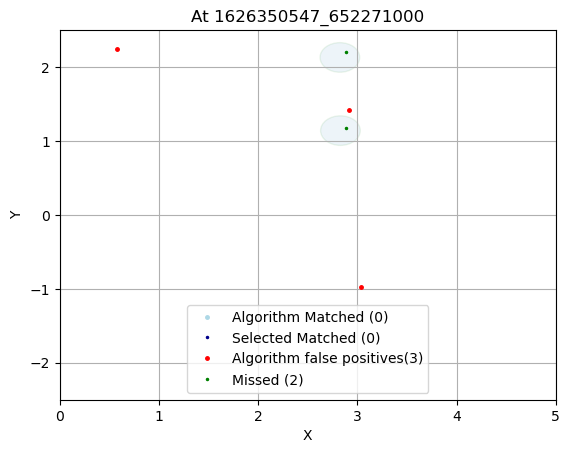

In [32]:
from collections import defaultdict
from matplotlib.patches import Rectangle, Circle
import matplotlib.pyplot as plt
from feature import group_features_by_timestamp
from plot_utils import plot_feature_with_bbox
from feature import group_features_by_timestamp, distance
import os
 
def is_point_in_bounding_box(point, box_size, bbox_center) -> bool:
    print (f"Point: {point[0]}, {point[1]}, bbox_center: {bbox_center[0]}, {bbox_center[1]}, {distance(bbox_center, point)}")
    return abs(distance(bbox_center, point)) < 0.2

def plot_feature(ax, features, label, color):
    mean_points_x = []
    mean_points_y = []
    mean_points_z = []
    for feature in features:
        mean_points_x.append(feature.box_center[0])
        mean_points_y.append(feature.box_center[1])
        mean_points_z.append(feature.box_center[2])
    ax.plot(mean_points_x, mean_points_y, ".", c=color, label=label, markersize=5)


def plot_feature_with_bbox(ax, features, label, color, bbox_color):
    mean_points_x = []
    mean_points_y = []
    mean_points_z = []
    for feature in features:
        mean_points_x.append(feature.mean_point[0])
        mean_points_y.append(feature.mean_point[1])
        mean_points_z.append(feature.mean_point[2])
        center = (
            feature.box_center[0] - feature.box_size[0] / 2.0,
            feature.box_center[1] - feature.box_size[1] / 2,
        )
        ax.add_patch(
            Circle(
                center,
                0.2,
                edgecolor=bbox_color,
                facecolor=None,
                alpha=0.08,
            )
        )
    ax.plot(mean_points_x, mean_points_y, ".", c=color, label=label, markersize=3)

timestamp = "1626350547_652271000"

def plot_compare_at_timestamp(timestamp):

    # return timestamp_dict
    grouped_features = group_features_by_timestamp(tp_features, alg_features)
    matched_alg = []
    alg_false = []
    tp_true = []

    grouped_features = dict(sorted(grouped_features.items()))
    features_at_timestamp = grouped_features[timestamp]

    selected_features_at_this_time = features_at_timestamp["tp"]
    algorithm_features_at_this_time = features_at_timestamp["alg"]

    for tp_feature in selected_features_at_this_time:
        for alg_feature in algorithm_features_at_this_time:
            if alg_feature.label == "matched":
                continue

            if is_point_in_bounding_box(
                alg_feature.mean_point, tp_feature.box_size, tp_feature.box_center
            ):
                tp_feature.label = "matched"
                alg_feature.label = "matched"
                break

    for alg_feature in algorithm_features_at_this_time:
        if alg_feature.label is None:
            alg_feature.label = "false"

    for tp_feature in selected_features_at_this_time:
        if tp_feature.label is None:
            tp_feature.label = "missed"




    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(f"At {timestamp}")
    ax.grid()
    # Set plot limits
    ax.set_xlim(0, 5)
    ax.set_ylim(-2.5, 2.5)

    # Set labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    matched_alg = [feature for feature in algorithm_features_at_this_time if feature.label == "matched"]
    matched_rviz = [feature for feature in selected_features_at_this_time if feature.label == "matched"]
    false_alg = [feature for feature in algorithm_features_at_this_time if feature.label == "false"]
    missed = [feature for feature in selected_features_at_this_time if feature.label == "missed"]

    # plot_feature_with_bbox(ax, selected_features_at_this_time, f"Selected by hand ({len(selected_features_at_this_time)})", "g", "g")
    plot_feature(ax, matched_alg, f"Algorithm Matched ({len(matched_alg)})", "lightblue")
    plot_feature_with_bbox(ax, matched_rviz, f"Selected Matched ({len(matched_rviz)})", "darkblue", "darkblue")
    plot_feature(ax, false_alg, f"Algorithm false positives({len(false_alg)})", "red")
    plot_feature_with_bbox(ax, missed, f"Missed ({len(missed)})", "green", "green")
    ax.legend(loc="lower center")


plot_compare_at_timestamp(timestamp)


selected_timestamps_path = f"./data/fall_corrected_split"
alg_timestamps_path = f"./data/pass2_alg_fast_split"
selected_timestamps = [folder for folder in os.listdir(selected_timestamps_path) if os.path.isdir(os.path.join(selected_timestamps_path, folder))]
alg_timestamps = [folder for folder in os.listdir(alg_timestamps_path) if os.path.isdir(os.path.join(alg_timestamps_path, folder))]
# print(selected_timestamps)
# print(alg_timestamps)

i = 0

for timestamp in selected_timestamps:
    if timestamp not in alg_timestamps:
        i+=1
        print(timestamp)
        
print(i)
i = 0

for timestamp in alg_timestamps :
    if timestamp not in selected_timestamps:
        print(timestamp)
        i+=1

print(i)

# Selected matched - lightblue
# Selected missed - green
# Algorithm matched - darkblue
# Algorithm false positives - red


